> # **<font color="darkcyan">Importing Libraries</font>**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pandas_profiling as pp
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

## **<font color="darkcyan">EDA</font>**

In [2]:
df = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")

In [3]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

> # **<font color="darkcyan">Analysis of Correlation</font>**

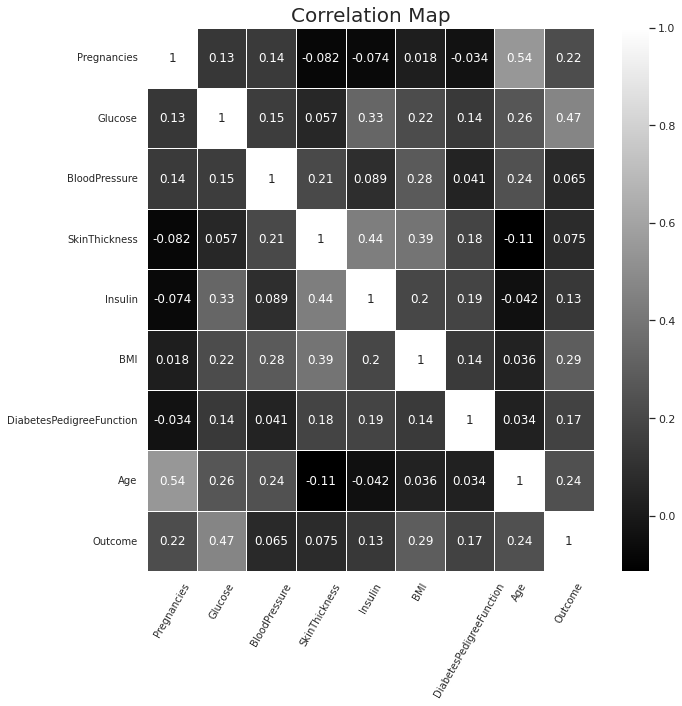

In [4]:
def correlated_map(dataframe, plot=False):
    corr = dataframe.corr()
    if plot:
        sns.set(rc={'figure.figsize': (10, 10)})
        sns.heatmap(corr, cmap="gist_yarg_r", annot=True, linewidths=.7)
        plt.xticks(rotation=60, size=10)
        plt.yticks(size=10)
        plt.title('Correlation Map', size=20)
        plt.show()

correlated_map(df, plot=True)

> # **<font color="darkcyan">Label Encoding</font>**

In [5]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
len(binary_cols)

0

In [6]:
for col in binary_cols:
    label_encoder(df, col)

df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1

> # **<font color="darkcyan">One-Hot Encoding</font>**

In [7]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols, drop_first=True)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1

> # **<font color="darkcyan">Standart Scaler</font>**

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [9]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age  Outcome
0          0.640    0.848          0.150          0.907   -0.693  0.204                     0.468  1.426        1
1         -0.845   -1.123         -0.161          0.531   -0.693 -0.684                    -0.365 -0.191        0
2          1.234    1.944         -0.264         -1.288   -0.693 -1.103                     0.604 -0.106        1
3         -0.845   -0.998         -0.161          0.155    0.123 -0.494                    -0.921 -1.042        0
4         -1.142    0.504         -1.505          0.907    0.766  1.410                     5.485 -0.020        1
..           ...      ...            ...            ...      ...    ...                       ...    ...      ...
763        1.828   -0.623          0.356          1.723    0.870  0.115                    -0.909  2.532        0
764       -0.548    0.035          0.046          0.405   -0.693  0.610                    -0.398 -0.531        0
765        0.343    0.003          0.150          0.155    0.280 -0.735                    -0.685 -0.276        0
766       -0.845    0.160         -0.471         -1.288   -0.693 -0.240                    -0.371  1.171        1
767       -0.845   -0.873          0.046          0.656   -0.693 -0.202                    -0.474 -0.871        0

[768 rows x 9 columns]

> # **<font color="softblue">Logistic Regression</font>**

In [10]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)


cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

y_pred = log_model.predict(X)

In [11]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



> # **<font color="softblue">Confusion Matrix</font>**

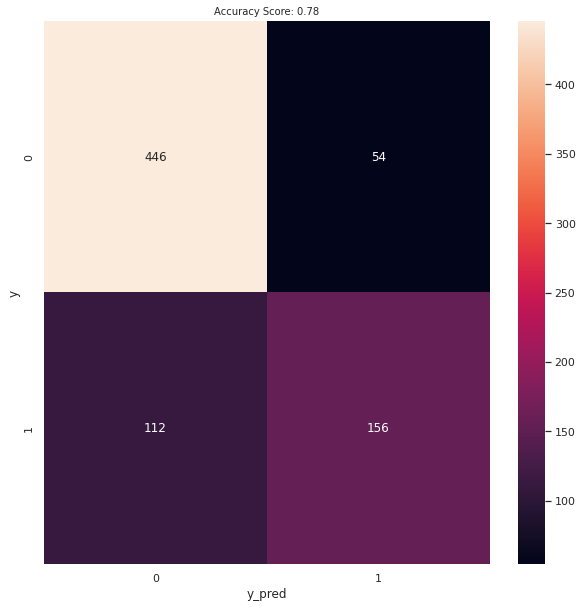

In [12]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

> # **<font color="softblue">ROC AUC</font>**

In [13]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8394029850746269

> # **<font color="softblue">Prediction for A New Observation</font>**

In [14]:
X.columns

random_user = X.sample(1, random_state=44)

log_model.predict(random_user)

array([0])

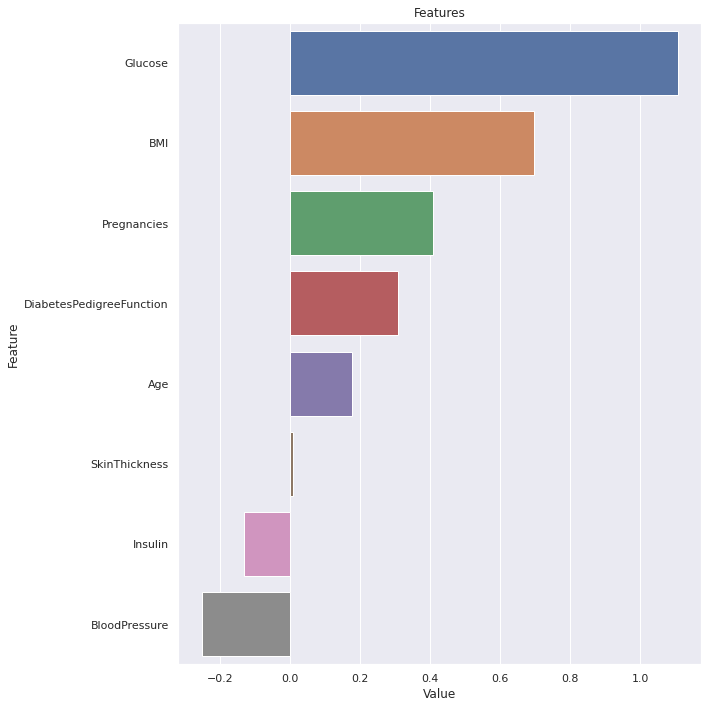

In [15]:
feature_imp = pd.DataFrame({'Value': log_model.coef_[0], 'Feature': X.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:8])
plt.title('Features')
plt.tight_layout()
plt.show()